<a href="https://colab.research.google.com/github/Leila828/Learning_JAX_for_deepLearning/blob/main/JAX_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project - GAN
Generative Adversarial Networks (GANs) were introduced by Ian Goodfellow, et al. in 2014. The ease of generating (usually images) using neural networks and backpropagation made it a quick success. GANs have already established themselves as a specialized field in Machine Learning.

There have been a lot of variants of GANs (as of writing it, NVIDIA has launched StyleGANv3 as well). In this project, we will implement Deep Convolution (DC-GAN).



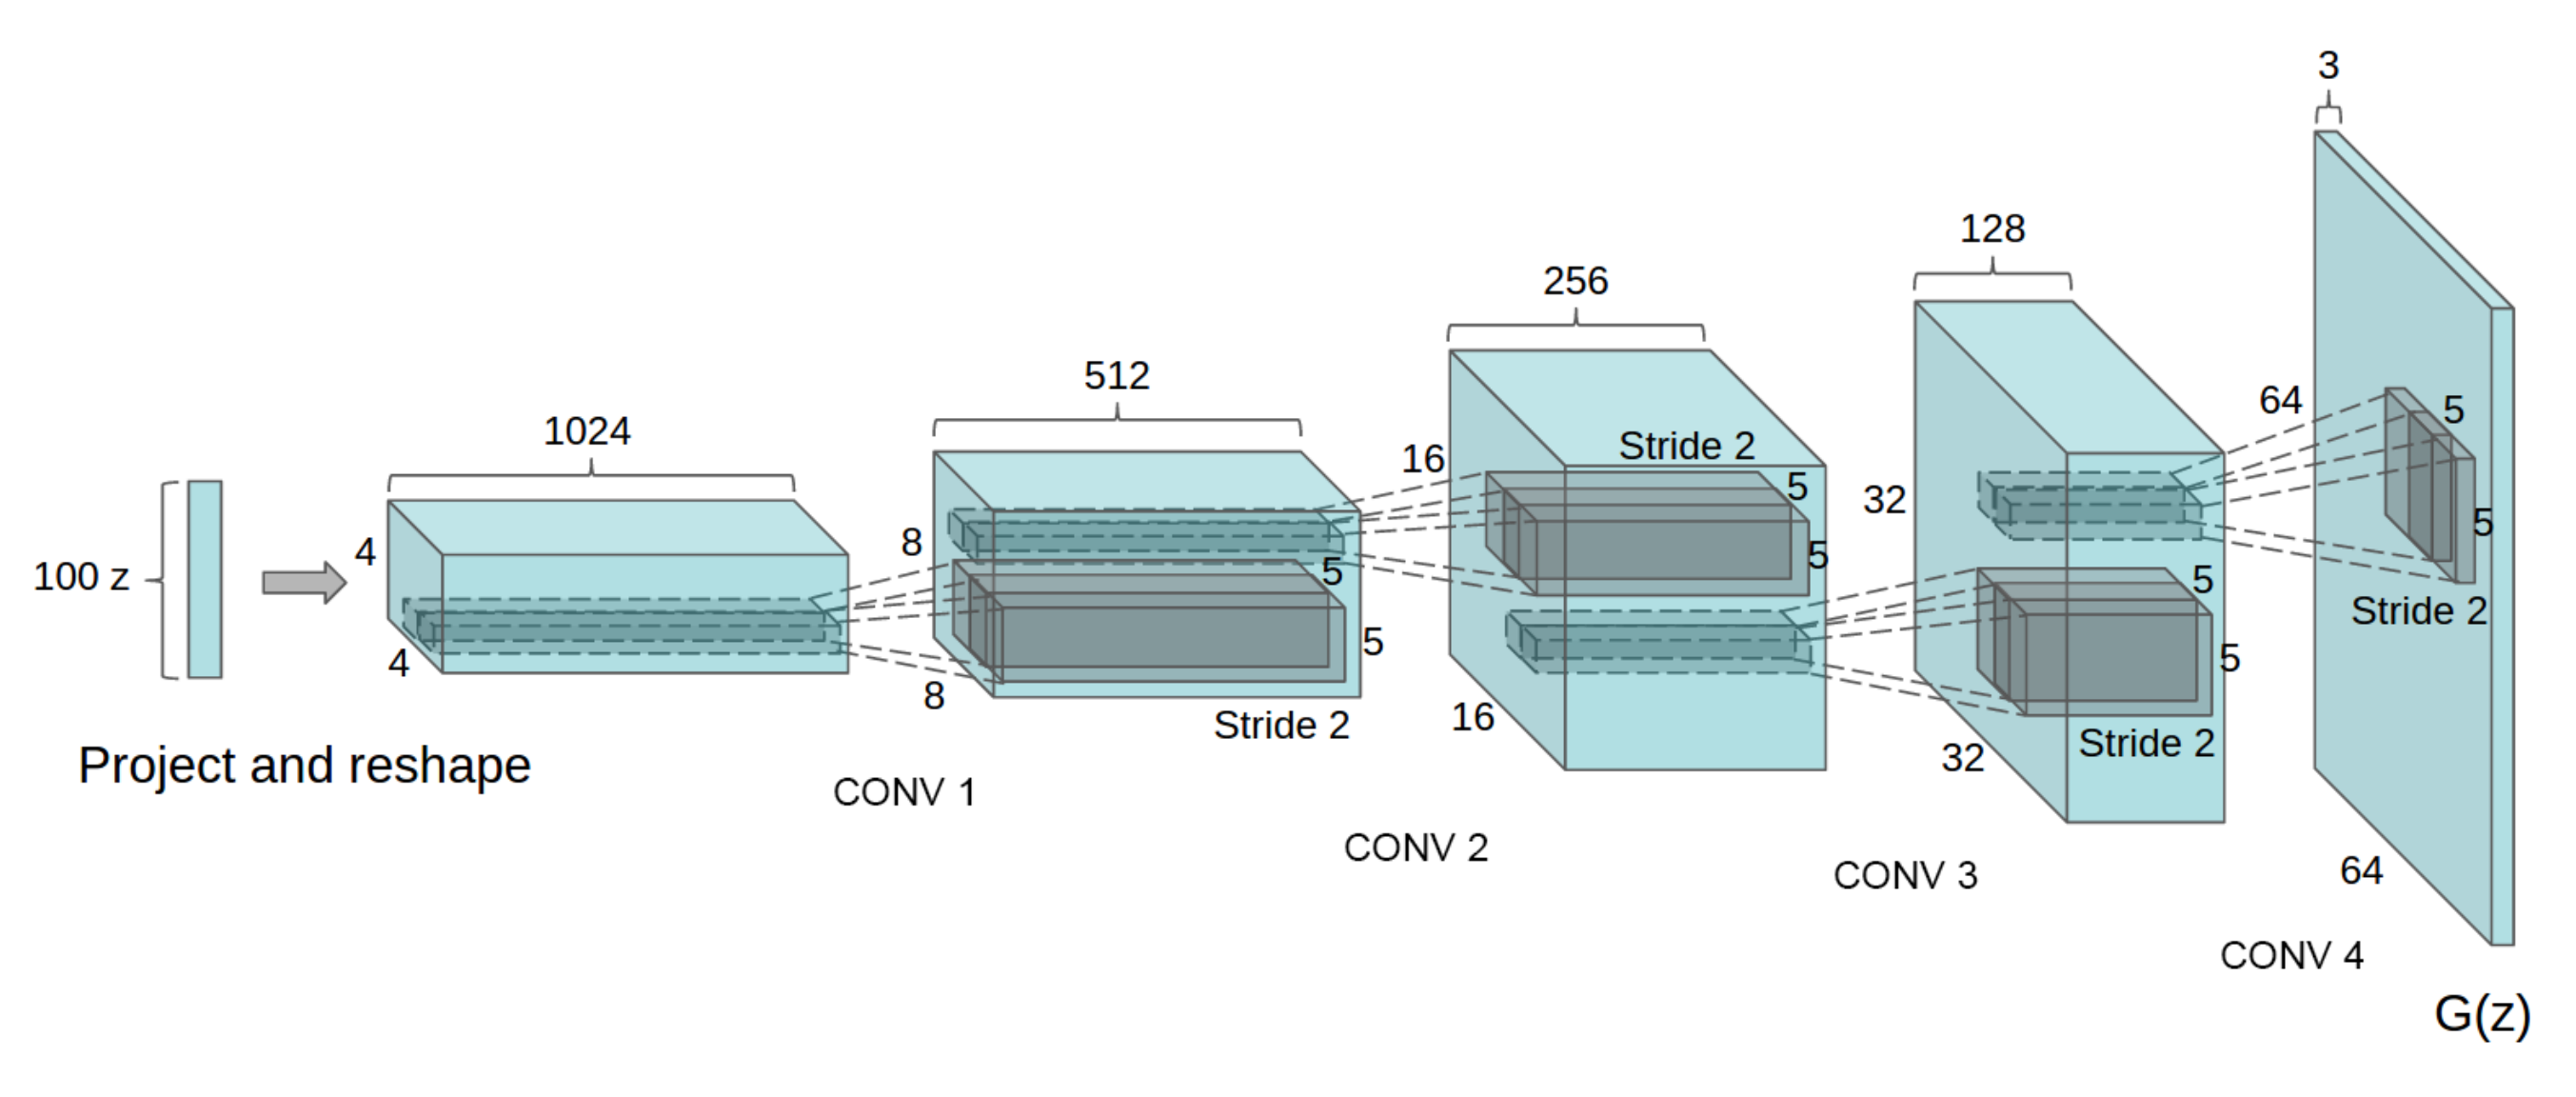

1. Imports
Import JAX, JAX NumPy, Flax, ordinary NumPy, and TensorFlow Datasets (TFDS). Flax can use any data-loading pipeline and this example demonstrates how to utilize TFDS.

In [ ]:
pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 2.1 MB/s 
     |████████████████████████████████| 145 kB 26.7 MB/s 
     |████████████████████████████████| 237 kB 27.8 MB/s 
     |████████████████████████████████| 51 kB 6.2 MB/s 
     |████████████████████████████████| 85 kB 3.8 MB/s 


In [ ]:
import os
from functools import partial

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import flax
from flax import linen as nn

import tensorflow as tf
import tensorflow_datasets as tfds

2. Define Generator and Discriminator
If you recall, a GAN consists of two networks: Generator and Discriminator - both competing against each other in a min-max game.

𝑚𝑖𝑛𝐺𝑚𝑎𝑥𝐷𝑉(𝐷,𝐺)=𝔼𝑥∼𝑝𝑑𝑎𝑡𝑎(𝑥)[𝑙𝑜𝑔𝐷(𝑥)]+𝔼𝑧∼𝑝𝑧(𝑧)[𝑙𝑜𝑔(1−𝐷(𝐺(𝑧))]
 
Creating a convolutional neural network is pretty straightforward with the Linen API by subclassing Module. Because the architecture in this example is relatively simple—you're just stacking layers—you can define the inlined submodules directly within the __call__ method and wrap it with the @compact decorator.

In [ ]:
class Generator(nn.Module):
    training: bool

    @nn.compact
    def __call__(self, z):
        x = nn.ConvTranspose(features=64*8, kernel_size=(4, 4),
                             strides=(1, 1), padding='VALID', use_bias=False)(z)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        #Repeat the block and remember this block should have half features. Rest is same.

        """Block/Layer 2 here"""
        x = nn.ConvTranspose(features=32*8, kernel_size=(4, 4),
                             strides=(1, 1), padding='VALID', use_bias=False)(z)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        #Similarly half the features from previous block
        
        """Block/layer 3 here"""
        x = nn.ConvTranspose(features=16*8, kernel_size=(4, 4),
                             strides=(1, 1), padding='VALID', use_bias=False)(z)
        x = nn.BatchNorm(
            use_running_average=not self.training, momentum=0.9)(x)
        x = nn.relu(x)

        x = nn.ConvTranspose(features=1, kernel_size=(
            4, 4), strides=(1, 1), padding='SAME', use_bias=False)(x)
        return jnp.tanh(x)

In [ ]:
class Discriminator(nn.Module):
    training: bool

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=64, kernel_size=(
            3, 3), strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        
        #Repeat the block and remember this block should have double features. Rest is same.

        """Block/Layer 2 here"""
        x = nn.Conv(features=128, kernel_size=(
            3, 3), strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)

        #Similarly double the features from previous block
        
        """Block/layer 3 here"""
        x = nn.Conv(features=256, kernel_size=(
            3, 3), strides=(2, 2), padding='SAME', use_bias=False)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)


        x = nn.Conv(features=1, kernel_size=(
            1, 1), strides=(4, 4), padding='VALID', use_bias=False)(x)
        x = jnp.reshape(x, [x.shape[0], -1])

        return x

3. Define loss
Recall that GAN uses a binary cross-entropy loss function. This BCE loss will be further used to define the Generator and Discriminator losses respectively.


In [ ]:
pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
@jax.vmap
def BCELoss(logit, label):
    return optax.sigmoid_binary_cross_entropy(logit, label)


def GeneratorLoss(generatorParams, discriminatorParams, batch, key, generatorVariables, discriminatorVariables):
    z = """Sample latent vector of 100 length using Normal/Gaussian distribution"""
    z =jax.random.normal(key,100)
    #Hints
    #Make PyTree for both generator and discriminator Variables 
    #Return the mean of BCE Loss for Generator+Discriminator
    return jnp.mean(BCELoss("""add the respective variables here""")


def DiscriminatorLoss(discriminatorParams, generatorParams, batch, key, generatorVariables, discriminatorVariables):
    z = """Sample latent vector of 100 length using Normal/Gaussian distribution"""

    return """Return consolidated loss by combining both real and fake losses"""

4. Loading data
For ease of use, this function is pre-implemented. MNIST is part of TF-Datasets (hence we imported TF and TF-DS at the start) and can be directly imported.

In [ ]:
def make_dataset(batch_size, seed=1):
    mnist = tfds.load("mnist")

    def _preprocess(sample):
        image = tf.image.convert_image_dtype(sample["image"], tf.float32)
        image = tf.image.resize(image, (32, 32))
        return 2.0 * image - 1.0

    ds = mnist["train"]
    ds = ds.map(map_func=_preprocess,
                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(10 * batch_size, seed=seed).repeat().batch(batch_size)
    return iter(tfds.as_numpy(ds))

5. Training step
Now we will define the training (step-by-step)

In [ ]:
@partial(jax.pmap, axis_name='batch')
def TrainingStep(key, generatorVariables, discriminatorVariables, generatorOptimizer, discriminatorOptimizer, batch):
    
    """your code here"""

    return key, generatorVariables, discriminatorVariables, generatorOptimizer, discriminatorOptimizer, discriminatorLoss, generatorLoss

Now consolidate it all by training the GAN

In [ ]:
def main():
    """Now consolidate it all"""
    return generatorLosses, discriminatorLosses

In [ ]:
generatorLosses, discriminatorLosses = main()